<img src="https://media.wired.com/photos/5c6c53bc0135c22d73b8ccd4/master/pass/ligo.jpg">

I am using spectrogram images generated by @yasufuminakama which can be found here for <a href="https://www.kaggle.com/yasufuminakama/g2net-spectrogram-generation-train">train</a> and here for <a href="https://www.kaggle.com/yasufuminakama/g2net-spectrogram-generation-test">test</a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import keras
import keras.layers as L
import math
from keras.utils import Sequence
from keras.preprocessing import image
from random import shuffle
from sklearn.model_selection import train_test_split

# About the Competition🚩
<p style="font-size:15px">It's been said that teamwork makes the dream work. This couldn't be truer for the breakthrough discovery of gravitational waves (GW), signals from colliding binary black holes in 2015. It required the collaboration of experts in physics, mathematics, information science, and computing. GW signals have led researchers to observe a new population of massive, stellar-origin black holes, to unlock the mysteries of neutron star mergers, and to measure the expansion of the Universe. These signals are unimaginably tiny ripples in the fabric of space-time and even though the global network of GW detectors are some of the most sensitive instruments on the planet, the signals are buried in detector noise. Analysis of GW data and the detection of these signals is a crucial mission for the growing global network of increasingly sensitive GW detectors. These challenges in data analysis and noise characterization could be solved with the help of data science.
</p><p>
In this competition, you’ll aim to detect GW signals from the mergers of binary black holes. Specifically, you'll build a model to analyze simulated GW time-series data from a network of Earth-based detectors.
</p><p>
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.
</p>

# Data Description

<div style="font-size:15px">
 We are given 2 npy files and 2 csv files:-
<ul>
    <li><code>train:</code> the training set files, one npy file per observation; labels are provided in a files shown below
</li>
    <li><code>test:</code> the test set files; you must predict the probability that the observation contains a gravitational wave</li>
    <li><code>training_labels.csv:</code> target values of whether the associated signal contains a gravitational wave</li>
    <li><code>sample_submission.csv:</code> a sample submission file in the correct format
</li>
</ul>    
</div>

# Train Dataset

# EDA

In [2]:
train_labels = pd.read_csv('../input/g2net-gravitational-wave-detection/training_labels.csv')
sample_submission = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')

Lets take a look at train_labels

In [3]:
train_labels.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


<AxesSubplot:xlabel='target', ylabel='count'>

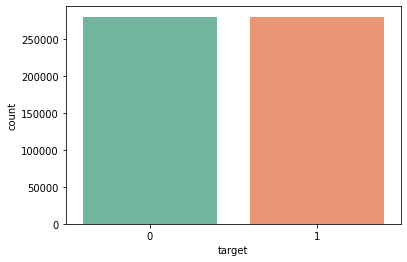

In [4]:
sns.countplot(x='target',data=train_labels,palette='Set2')

In [5]:
path = list(train_labels['id'])
for i in range(len(path)):
    path[i] = '../input/g2net-gravitational-wave-detection/train/' +path[i][0]+'/'+path[i][1]+'/'+path[i][2]+'/' + path[i] + '.npy'

In [6]:
def id2path(idx,is_train=True):
    path = '../input/g2net-gravitational-wave-detection'
    if is_train:
        path += '/train/'+idx[0]+'/'+idx[1]+'/'+idx[2]+'/'+idx+'.npy'
    else:
        path += '/test/'+idx[0]+'/'+idx[1]+'/'+idx[2]+'/'+idx+'.npy'
    return path

In [7]:
!pip install -q nnAudio

In [8]:
import torch
from nnAudio.Spectrogram import CQT1992v2
def increase_dimension(idx,is_train,transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)): # in order to use efficientnet we need 3 dimension images
    waves = np.load(id2path(idx,is_train))
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves)
    image = np.array(image)
    image = np.transpose(image,(1,2,0))
    return image

CQT kernels created, time used = 0.0397 seconds


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


lets take a look at example file

In [9]:
example = np.load(path[0])

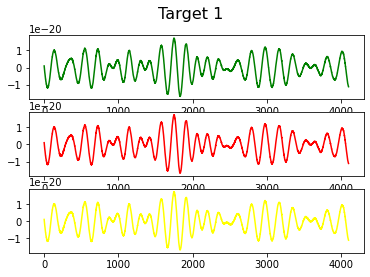

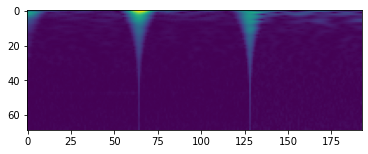

In [10]:
fig,a =  plt.subplots(3,1)
a[0].plot(example[1],color='green')
a[1].plot(example[1],color='red')
a[2].plot(example[1],color='yellow')
fig.suptitle('Target 1', fontsize=16)
plt.show()
plt.imshow(increase_dimension(train_labels['id'][0],is_train=True))
plt.show()

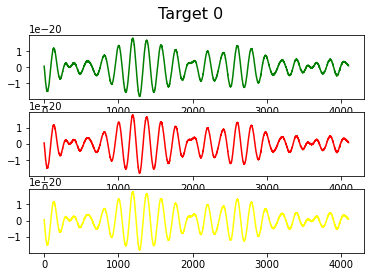

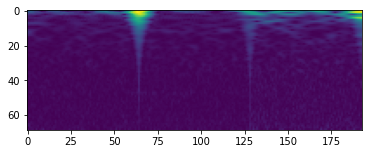

In [11]:
example = np.load(path[1])
fig,a =  plt.subplots(3,1)
a[0].plot(example[1],color='green')
a[1].plot(example[1],color='red')
a[2].plot(example[1],color='yellow')
fig.suptitle('Target 0', fontsize=16)
plt.show()
plt.imshow(increase_dimension(train_labels['id'][1],is_train=True))
plt.show()

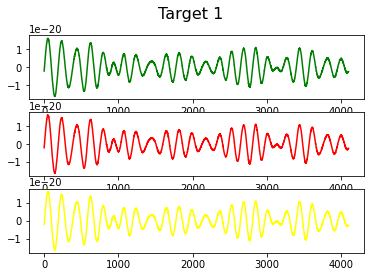

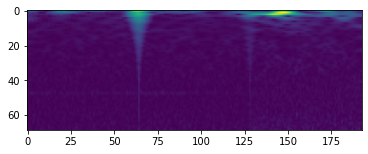

In [12]:
example = np.load(path[4])
fig,a =  plt.subplots(3,1)
a[0].plot(example[1],color='green')
a[1].plot(example[1],color='red')
a[2].plot(example[1],color='yellow')
fig.suptitle('Target 1', fontsize=16)
plt.show()
plt.imshow(increase_dimension(train_labels['id'][4],is_train=True))
plt.show()

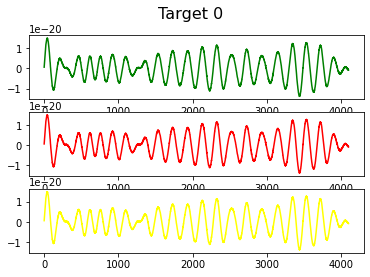

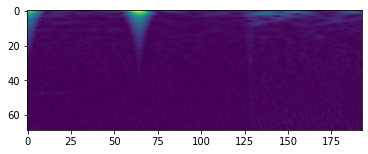

In [13]:
example = np.load(path[2])
fig,a =  plt.subplots(3,1)
a[0].plot(example[1],color='green')
a[1].plot(example[1],color='red')
a[2].plot(example[1],color='yellow')
fig.suptitle('Target 0', fontsize=16)
plt.show()
plt.imshow(increase_dimension(train_labels['id'][2],is_train=True))
plt.show()

# Model

In [14]:
class Dataset(Sequence):
    def __init__(self,idx,y=None,batch_size=256,shuffle=True):
        self.idx = idx
        self.batch_size = batch_size
        self.shuffle = shuffle
        if y is not None:
            self.is_train=True
        else:
            self.is_train=False
        self.y = y
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
    def __getitem__(self,ids):
        batch_ids = self.idx[ids * self.batch_size:(ids + 1) * self.batch_size]
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
            
        list_x = np.array([increase_dimension(x,self.is_train) for x in batch_ids])
        batch_X = np.stack(list_x)
        if self.is_train:
            return batch_X, batch_y
        else:
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))

In [15]:
train_idx =  train_labels['id'].values
y = train_labels['target'].values
test_idx = sample_submission['id'].values

In [16]:
x_train,x_valid,y_train,y_valid = train_test_split(train_idx,y,test_size=0.05,random_state=42,stratify=y)

In [17]:
train_dataset = Dataset(x_train,y_train)
valid_dataset = Dataset(x_valid,y_valid)
test_dataset = Dataset(test_idx)

In [18]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 1.5 MB/s 


In [19]:
import efficientnet.keras as efn

Since efficient net requires image shape to be at least 32X32 I am first using a Conv layer to increase channels to 6 then using reshape to increase image size if someone has a better way then please suggest

In [20]:
model = tf.keras.Sequential([L.InputLayer(input_shape=(69,193,1)),L.Conv2D(3,3,activation='relu',padding='same'),efn.EfficientNetB0(include_top=False,input_shape=(),weights='imagenet'),
        L.GlobalAveragePooling2D(),
        L.Dense(32,activation='relu'),
        L.Dense(1, activation='sigmoid')])

model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=[keras.metrics.AUC()])


16809984/16804768 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 69, 193, 3)        30        
_________________________________________________________________
efficientnet-b0 (Functional) (None, None, None, 1280)  4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                40992     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,090,619
Trainable params: 4,048,603
Non-trainable params: 42,016
_________________________________________________________________


In [21]:
model.fit(train_dataset,epochs=2,validation_data=valid_dataset)

Epoch 1/2
2079/2079 [==============================] - 6294s 3s/step - loss: 0.4865 - auc: 0.8202 - val_loss: 0.4436 - val_auc: 0.8524
Epoch 2/2
2079/2079 [==============================] - 6601s 3s/step - loss: 0.4409 - auc: 0.8546 - val_loss: 0.4637 - val_auc: 0.8526


In [22]:
preds = model.predict(test_dataset)
preds = preds.reshape(-1)

In [23]:
submission = pd.DataFrame({'id':sample_submission['id'],'target':preds})

In [24]:
submission.to_csv('submission.csv',index=False)

<h2><center>If you found this notebook useful please upvote</center></h2>

<h2><center>Work in Progress ... ⏳</center></h2>